<a href="https://colab.research.google.com/github/leiyi-ihb/ColabPractics/blob/main/lyProject/Genomics_Machine_LearningJF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### An Example Machine Learning Application in Genomics

In [ ]:
import os
import time
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

main_dir = "./"
os.chdir(main_dir)

/content


In [ ]:
import pickle
with open("dataset_Li.pkl", "rb") as f:
    data = pickle.load(f)
    
    
# Describe data
# data is a Python dictionary with keys 'train', 'val', 'test'
print(type(data), data.keys())
# train has N=16000 datapoints for training the model
print('train', data['train'][0].shape, data['train'][1].shape)
# val has N=2000 datapoints for training the model
print('val', data['val'][0].shape, data['val'][1].shape)
# test has N=2000 datapoints for training the model
print('test', data['test'][0].shape, data['test'][1].shape)

FileNotFoundError: ignored

### Modeling: conventional machine learning

#### 0. Evaluation Metrics

In [ ]:
# Evaluation
# compute FPR, TPR, Precision at specific cutoff
def compute_FPR_TPR(ytrue, ypred, cutoff=0.5):
    # evaluation
    ypred[ypred>=cutoff] = 1
    ypred[ypred<cutoff] = 0
    total_n = len(ytrue)
    total_p = sum(ytrue)
    #
    TP = sum(ytrue[ypred==1])
    FN = sum(ytrue[ypred==0])
    FP = sum(ypred) - TP
    TN = len(ypred[ypred==0]) - FN
    if (total_n == TP + FN + FP + TN) & (total_p == TP + FN):
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        precision = TP / len(ypred[ypred==1])
        return TPR, FPR, precision
    

# evaluation function
def evaluation_func(y_val, y_pred, y_pred_proba, cutoff=0.5):
    from sklearn.metrics import accuracy_score
    from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc
    
    # data formulation
    data = pd.DataFrame()
    data['ytrue'] = list(y_val[:, 0])
    data['ypred'] = y_pred
    data['ypred_proba'] = y_pred_proba
    y_val = data['ytrue']
    ypred = data['ypred']
    ypred_proba = data['ypred_proba']
    # ROC & PR AUC
    roc_score = roc_auc_score(y_val, y_pred_proba)
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred_proba)
    pr_score = auc(recall, precision)
    # accuracy
    acc_score = accuracy_score(y_pred, y_val)
    # TPR & FPR
    TPR, FPR, precision = compute_FPR_TPR(y_val, y_pred_proba, cutoff=cutoff)
    return (roc_score, pr_score, acc_score, TPR, FPR)

#### 1 Logistic Regression

#### 1.1 Feature Engineering & Modeling Function

In [ ]:
# Feature Engineering
def feature_onehot(x_data):
    x_new_data = x_data.reshape(x_data.shape[0], x_data.shape[1]*x_data.shape[2])
    return x_new_data


# prediction
def predict(model, x_val):
    y_pred = model.predict(x_val)
    y_pred_proba = model.predict_proba(x_val)[:, 1]
    return (y_pred, y_pred_proba)


# Modeling
def LR_train(x_train, y_train, penalty, C=1.0, solver="liblinear"):
    from sklearn.linear_model import LogisticRegression
    
    model = LogisticRegression(penalty=penalty, C=C, solver=solver)
    # 训练模型
    model.fit(x_train, y_train)
    return model

In [ ]:
# test
# training
penalty = 'l2'
C = 1.0
solver = "liblinear"
x_train = feature_onehot(data['train'][0])
y_train = data['train'][1]
model = LR_train(x_train, y_train, penalty, C=C, solver=solver)
# predict & evaluate
y_pred, y_pred_proba = predict(model, x_train)
roc_score, pr_score, acc_score, TPR, FPR = evaluation_func(y_train, y_pred, y_pred_proba)
print("ROC AUC:", roc_score)
print("PR AUC:", pr_score)
print("Auccracy:", acc_score)
print("TPR:", TPR)
print("FPR:", FPR)

ROC AUC: 0.7673981278898937
PR AUC: 0.7648966351461975
Auccracy: 0.6936875
TPR: 0.6929330831769857
FPR: 0.3055590256089944


#### 1.2 Parameter Optimization

In [ ]:
def LR_training(x_train, y_train, x_val, y_val, 
                params
               ):
    # training
    x_train = feature_onehot(x_train)
    x_val = feature_onehot(x_val)
    penalty, C, solver = params
    model = LR_train(x_train, y_train, penalty, C=C, solver=solver)
    
    # predict & evaluate 
    # for train data
    y_pred_train, y_pred_proba_train = predict(model, x_train)
    roc_score_train, pr_score_train, acc_score_train, TPR_train, FPR_train = evaluation_func(y_train, 
                                                                                             y_pred_train, 
                                                                                             y_pred_proba_train)
    # for val data
    y_pred_val, y_pred_proba_val = predict(model, x_val)
    roc_score_val, pr_score_val, acc_score_val, TPR_val, FPR_val = evaluation_func(y_val, 
                                                                                   y_pred_val, 
                                                                                   y_pred_proba_val)
    # result
    result = pd.DataFrame()
    result['Algorithm'] = ["LogisticRegression" ]
    result['penalty'] = [penalty]
    result['C'] = [C]
    result['solver'] = [solver]
    result['Accuracy-train'] = acc_score_train
    result['Accuracy-val'] = acc_score_val
    result['ROC-train'] = roc_score_train
    result['ROC-val'] = roc_score_val
    result['PR-train'] = pr_score_train
    result['PR-val'] = pr_score_val
    result['TPR-train'] = TPR_train
    result['TPR-val'] = TPR_val
    result['FPR-train'] = FPR_train
    result['FPR-val'] = FPR_val
    return result, model
    
    
def LR_opt_hyperparameters(x_train, y_train, x_val, y_val, 
                           solver, penalty, C_list):
    result_list = []
    for C in C_list:
        params = (penalty, C, solver)
        result, model = LR_training(x_train, y_train, x_val, y_val, params)
        result_list.append(result)
    result = pd.concat(result_list, axis=0)
    result.reset_index(drop=True, inplace=True)
    return result

In [ ]:
# opt parameters for l1
x_train = data['train'][0]
y_train = data['train'][1]
x_val = data['val'][0]
y_val = data['val'][1]

# round 1
solver = "liblinear"
penalty = "l1"
C_list = [0.001, 0.05, 0.1, 0.5, 1, 10, 50, 100, 200, 300, 400, 500]
result1 = LR_opt_hyperparameters(x_train, y_train, x_val, y_val, solver, penalty, C_list)

# round 2
C_list = np.linspace(0.5, 10, 50)
result2 = LR_opt_hyperparameters(x_train, y_train, x_val, y_val, solver, penalty, C_list)
result = pd.concat([result1, result2], axis=0)
result.to_excel("./LR_parameter_optimization-l1.xlsx", index=False)
result.head()

,Algorithm,penalty,C,solver,Accuracy-train,Accuracy-val,ROC-train,ROC-val,PR-train,PR-val,TPR-train,TPR-val,FPR-train,FPR-val
0,LogisticRegression,l1,0.001,liblinear,0.500313,0.5035,0.500000,0.500000,0.749844,0.748250,1.000000,1.000000,1.000000,1.000000
1,LogisticRegression,l1,0.050,liblinear,0.669875,0.5185,0.737424,0.531397,0.733431,0.520350,0.665791,0.521652,0.326046,0.484608
2,LogisticRegression,l1,0.100,liblinear,0.688688,0.5245,0.757376,0.534364,0.754806,0.525360,0.687054,0.533736,0.309681,0.484608
3,LogisticRegression,l1,0.500,liblinear,0.693750,0.5205,0.766861,0.534318,0.764311,0.527278,0.692683,0.520645,0.305184,0.479643
4,LogisticRegression,l1,1.000,liblinear,0.694000,0.5215,0.767261,0.534734,0.764764,0.527581,0.693058,0.521652,0.305059,0.478649


In [ ]:
# opt parameters for l2
x_train = data['train'][0]
y_train = data['train'][1]
x_val = data['val'][0]
y_val = data['val'][1]

# round 1
solver = "liblinear"
penalty = "l2"
C_list = [0.001, 0.05, 0.1, 0.5, 1, 10, 50, 100, 200, 300, 400, 500]
result1 = LR_opt_hyperparameters(x_train, y_train, x_val, y_val, solver, penalty, C_list)

# round 2
C_list = np.linspace(0.001, 0.5, 50)
result2 = LR_opt_hyperparameters(x_train, y_train, x_val, y_val, solver, penalty, C_list)
result = pd.concat([result1, result2], axis=0)
result.to_excel("./LR_parameter_optimization-l2.xlsx", index=False)
result.head()

,Algorithm,penalty,C,solver,Accuracy-train,Accuracy-val,ROC-train,ROC-val,PR-train,PR-val,TPR-train,TPR-val,FPR-train,FPR-val
0,LogisticRegression,l2,0.001,liblinear,0.685000,0.5125,0.758716,0.534916,0.754564,0.532189,0.682051,0.524673,0.312055,0.499503
1,LogisticRegression,l2,0.050,liblinear,0.694375,0.5210,0.767351,0.535092,0.764816,0.528056,0.693809,0.524673,0.305059,0.482622
2,LogisticRegression,l2,0.100,liblinear,0.694312,0.5200,0.767384,0.535055,0.764864,0.528031,0.694059,0.524673,0.305434,0.484608
3,LogisticRegression,l2,0.500,liblinear,0.693688,0.5185,0.767395,0.535065,0.764893,0.528077,0.692933,0.524673,0.305559,0.487587
4,LogisticRegression,l2,1.000,liblinear,0.693688,0.5195,0.767398,0.535086,0.764897,0.528100,0.692933,0.525680,0.305559,0.486594


#### 1.3 Best Modeling & Evaluation

In [ ]:
# Best Modeling
# data
x_train = data['train'][0]
y_train = data['train'][1]
x_val = data['val'][0]
y_val = data['val'][1]
x_test = data['test'][0]
y_test = data['test'][1]

# training for best parameters
best_params_l1 = ("l1", 0.1, "liblinear")
best_params_l2 = ("l2", 0.0316, "liblinear")
result_val_l1, best_model_l1 = LR_training(x_train, y_train, x_val, y_val, best_params_l1)
result_val_l2, best_model_l2 = LR_training(x_train, y_train, x_val, y_val, best_params_l2)
result_test_l1, best_model_l1 = LR_training(x_train, y_train, x_test, y_test, best_params_l1)
result_test_l2, best_model_l2 = LR_training(x_train, y_train, x_test, y_test, best_params_l2)

# save best model
import joblib

save_best_model_l1_path = "./result/LR_l1.model"
save_best_model_l2_path = "./result/LR_l2.model"
joblib.dump(best_model_l1, save_best_model_l1_path)
joblib.dump(best_model_l2, save_best_model_l2_path)
# model = joblib.load(save_best_model_path) # 加载

# save evaluation result
save_best_result = "./result/LR_best_evaluation.xlsx"
result_val_l1['dataset_evaluated'] = 'validation'
result_val_l2['dataset_evaluated'] = 'validation'
result_test_l1['dataset_evaluated'] = 'test'
result_test_l2['dataset_evaluated'] = 'test'
result = pd.concat([result_val_l1, result_test_l1, result_val_l2, result_test_l2], axis=0)
result.reset_index(drop=True, inplace=True)
result.to_excel(save_best_result, index=False)
result

,Algorithm,penalty,C,solver,Accuracy-train,Accuracy-val,ROC-train,ROC-val,PR-train,PR-val,TPR-train,TPR-val,FPR-train,FPR-val,dataset_evaluated
0,LogisticRegression,l1,0.1000,liblinear,0.688688,0.5245,0.757377,0.534364,0.754807,0.525362,0.687054,0.533736,0.309681,0.484608,validation
1,LogisticRegression,l1,0.1000,liblinear,0.688688,0.5255,0.757377,0.547955,0.754807,0.546682,0.687054,0.523715,0.309681,0.472672,test
2,LogisticRegression,l2,0.0316,liblinear,0.694750,0.5225,0.767287,0.535144,0.764733,0.528458,0.694434,0.525680,0.304934,0.480636,validation
3,LogisticRegression,l2,0.0316,liblinear,0.694750,0.5335,0.767287,0.549848,0.764733,0.543911,0.694434,0.525692,0.304934,0.458502,test


#### 1.4 Interpretation

In [ ]:
def LR_model_coef(best_model_path):
    # load best model
    import joblib
    
    model = joblib.load(best_model_path)
    model_importance = model.coef_
    return model_importance


def feature_labeling(model_importance):
    # feature engineering
    feat_label_list = []
    for i in range(4000):
        feat_pos = i // 4
        feat_rem = i % 4
        if feat_rem == 0:
            nucle = "A"
        elif feat_rem == 1:
            nucle = "C"
        elif feat_rem == 2:
            nucle = "G"
        else:
            nucle = "T"
        feat_label = "postion %s-%s"%(feat_pos + 1, nucle)
        feat_label_list.append(feat_label)
    feat_data = pd.DataFrame({"Feature": feat_label_list})
    feat_data['Weight coefficient'] = model_importance[0]
    feat_data['ABS of Weight coefficient'] = feat_data['Weight coefficient'].apply(lambda x: abs(x))
    print(feat_data.shape)
    feat_data.sort_values(by='ABS of Weight coefficient', ascending=False, inplace=True)
    feat_data.reset_index(drop=True, inplace=True)
    return feat_data


best_model_path = "./result/LR_l2.model"
model_importance = LR_model_coef(best_model_path)
feat_data = feature_labeling(model_importance)
feat_data.to_excel("./result/LR_l2_feature_importance.xlsx", index=False)
feat_data.head()

(4000, 3)


,Feature,Weight coefficient,ABS of Weight coefficient
0,postion 132-C,0.141465,0.141465
1,postion 772-C,0.134401,0.134401
2,postion 763-T,-0.129024,0.129024
3,postion 435-T,-0.124832,0.124832
4,postion 956-G,0.123105,0.123105


#####  Visualize model interpretation results

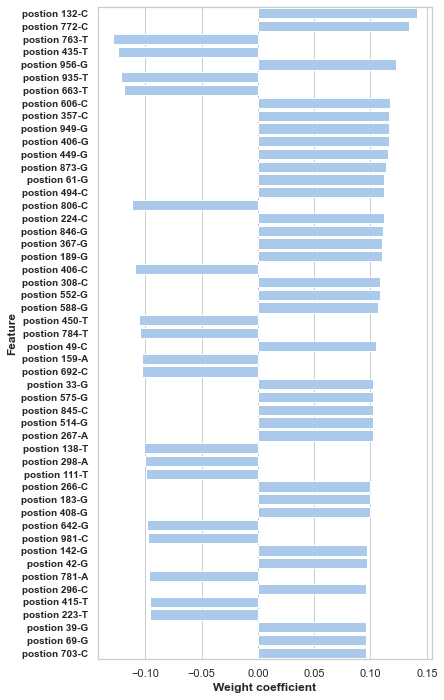

In [ ]:
# plot for top 50 important features
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

#设置子图的大小
top = 50
f, ax = plt.subplots(figsize=(6, 12))
sns.set_color_codes("pastel")
sns.barplot(x="Weight coefficient", y="Feature", data=feat_data.loc[:50, :], color="b")
plt.xlabel('Weight coefficient', fontsize=12, weight='bold')
plt.ylabel('Feature', fontsize=12, weight='bold')
plt.yticks(fontsize=10, weight='bold')
## xlim
# plt.xlim(0, 0.06)
savefig_path = './result/LR-Feature Importance-Top50.png'
plt.savefig(savefig_path, dpi=300, bbox_inches = 'tight')
plt.show()